In [1]:
%cd c:/Users/realc/OneDrive/Documents/UGR/kpr_nn
%pwd

c:\Users\realc\OneDrive\Documents\UGR\kpr_nn


c:\Users\realc\OneDrive\Documents\UGR\kpr_nn\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'c:\\Users\\realc\\OneDrive\\Documents\\UGR\\kpr_nn'

In [2]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torchvision import transforms
from torch.utils.data import Subset, DataLoader

from utils import data_prep

## Load the data

In [24]:
transform = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.ToTensor(),
])

batch_size = 32
num_samples = batch_size * 8

dataset = data_prep.ConeDataset("data/cone_img", "data/annotations", transform=transform)
total_samples = len(dataset)
indices = random.sample(range(total_samples), num_samples)
# subset = Subset(dataset, indices)

train_size = int(0.6 * num_samples)
test_size = num_samples - train_size

train_indices, test_indices = indices[:train_size], indices[train_size:]
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

# data_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

In [25]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class KPR_NN(nn.Module):
    def __init__(self, num_keypoints=6):
        super(KPR_NN, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=6, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.res_block1 = ResNetBlock(64, 64)
        self.res_block2 = ResNetBlock(64, 128, stride=2)
        self.res_block3 = ResNetBlock(128, 256, stride=2)
        self.res_block4 = ResNetBlock(256, 512, stride=2)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_keypoints * 2)
        
    def forward(self, x):
        x = self.initial_conv(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.res_block4(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = KPR_NN()
print(model)

KPR_NN(
  (initial_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(6, 6), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (res_block1): ResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (res_block2): ResNetBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stri

In [26]:
for batch_idx, batch in enumerate(train_loader):
    print(f"Batch {batch_idx}: {batch}")
    if batch is None:
        print("Warning: Found a batch that is None")
    else:
        images, keypoints = batch
        print(f"Batch {batch_idx} - Images shape: {images.shape}, Keypoints shape: {keypoints.shape}")

Returning dummy values instead of None
Batch 0: [tensor([[[[0.4784, 0.4863, 0.4824,  ..., 0.4000, 0.3686, 0.3255],
          [0.4824, 0.4863, 0.4745,  ..., 0.3843, 0.3608, 0.3098],
          [0.5137, 0.4902, 0.4941,  ..., 0.4039, 0.3608, 0.3137],
          ...,
          [0.4980, 0.5059, 0.4902,  ..., 0.6235, 0.5804, 0.5647],
          [0.4980, 0.4863, 0.4902,  ..., 0.6902, 0.6706, 0.6588],
          [0.4941, 0.5020, 0.4902,  ..., 0.6941, 0.6706, 0.6667]],

         [[0.4667, 0.4745, 0.4706,  ..., 0.4275, 0.4118, 0.3843],
          [0.4706, 0.4745, 0.4627,  ..., 0.4118, 0.4039, 0.3765],
          [0.5020, 0.4784, 0.4824,  ..., 0.4196, 0.3922, 0.3804],
          ...,
          [0.4706, 0.4588, 0.4314,  ..., 0.5882, 0.5647, 0.5686],
          [0.4784, 0.4588, 0.4471,  ..., 0.6588, 0.6549, 0.6510],
          [0.4824, 0.4863, 0.4627,  ..., 0.6745, 0.6588, 0.6627]],

         [[0.4078, 0.4157, 0.4118,  ..., 0.4235, 0.4314, 0.4353],
          [0.4118, 0.4157, 0.4039,  ..., 0.4118, 0.4196, 0.

In [27]:
def train_model(model, dataloader, num_epochs=20, lr=1e-3, device="cuda"):
    model.to(device)
    # Try MSE to begin with, then implement the proposed cross-ratio loss
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for batch in dataloader:
            if batch is None:
                print("None batch")
                continue
            # print(len(batch))

            images, keypoints = batch
            images, keypoints = images.to(device), keypoints.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            keypoints = keypoints.view(keypoints.shape[0], -1)
            loss = criterion(outputs, keypoints)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return model

device = "cuda" if torch.cuda.is_available() else "cpu"
trained_model = train_model(model, train_loader, num_epochs=20, lr=1e-3, device=device)

Returning dummy values instead of None
Returning dummy values instead of None
Returning dummy values instead of None
Epoch [1/20], Loss: 1986.4073
Returning dummy values instead of None
Returning dummy values instead of None
Returning dummy values instead of None
Epoch [2/20], Loss: 1802.1676
Returning dummy values instead of None
Returning dummy values instead of None
Returning dummy values instead of None
Epoch [3/20], Loss: 1644.5006
Returning dummy values instead of None
Returning dummy values instead of None
Returning dummy values instead of None
Epoch [4/20], Loss: 1483.7497
Returning dummy values instead of None
Returning dummy values instead of None
Returning dummy values instead of None
Epoch [5/20], Loss: 1322.4438
Returning dummy values instead of None
Returning dummy values instead of None
Returning dummy values instead of None
Epoch [6/20], Loss: 1169.8463
Returning dummy values instead of None
Returning dummy values instead of None
Returning dummy values instead of None
E

In [28]:
def predict_keypoints(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()
    
    predictions = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images, _ = batch
            images = images.to(device)
            
            outputs = model(images)
            outputs = outputs.cpu().numpy()
            
            for i in range(outputs.shape[0]):
                predicted_keypoints = outputs[i].reshape(6, 2)
                predictions.append(predicted_keypoints)
    
    return predictions

predicted_keypoints = predict_keypoints(trained_model, test_loader, device=device)

for i, keypoints in enumerate(predicted_keypoints[:3]):
    print(f"Image {i}: Predicted Keypoints:\n{keypoints}")


Image 0: Predicted Keypoints:
[[17.001972 51.139812]
 [22.511139 42.876698]
 [27.48955  23.739496]
 [46.927372 23.406044]
 [48.5876   42.8465  ]
 [50.53753  51.46525 ]]
Image 1: Predicted Keypoints:
[[17.42907  52.431908]
 [23.009422 43.932083]
 [28.151577 24.312332]
 [48.131416 23.958906]
 [49.806335 43.856434]
 [51.758423 52.70529 ]]
Image 2: Predicted Keypoints:
[[17.492455 52.592754]
 [23.069374 44.064198]
 [28.251982 24.377703]
 [48.289738 24.036766]
 [49.98819  44.006447]
 [51.945885 52.90014 ]]


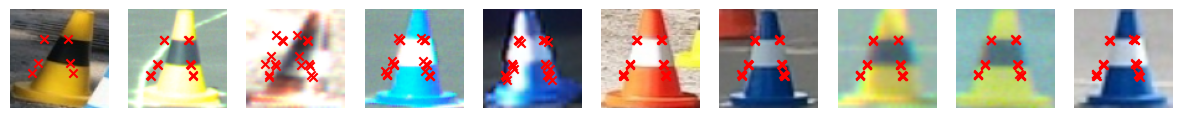

In [ ]:
import matplotlib.pyplot as plt

def plot_predicted_keypoints(model, test_loader, device="cuda", num_images=5):
    model.to(device)
    model.eval()
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    predictions = predict_keypoints(model, test_loader, device)

    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            if i >= num_images:
                break

            images = images.to(device)
            batch_size = images.shape[0]

            for j in range(min(batch_size, num_images - i)):
                img = images[j].cpu().permute(1, 2, 0).numpy()
                keypoints = predictions[i * batch_size + j]
                
                ax = axes[i + j]
                ax.imshow(img, cmap="gray")
                ax.scatter(keypoints[:, 0], keypoints[:, 1], c="red", marker="x")
                ax.axis("off")
                
    plt.show()

plot_predicted_keypoints(trained_model, test_loader, device=device, num_images=10)
